In [1]:
# import 
import os
import datetime
import time

import ipywidgets as widgets
from IPython.display import display

import IPython
import IPython.display
# import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import clear_output

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from math import sqrt
from numpy import concatenate
import numpy as np
import math

import pandas as pd
from pandas import DataFrame
from pandas import concat

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# import tensorflow 
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.layers import BatchNormalization

import platform
print(platform.python_version())
print(np.__version__)
print(tf.__version__)

# tf.config.list_physical_devices('GPU')

3.9.7
1.21.2
2.7.0


In [20]:
# File name and Path
cwd = os.getcwd()
path_adress = "/Import_Dataset/"

# ข้อมูล พิกัดสถานที่เเละรายชื้ออ้างอิงสถานที่ตรวจวัด
file_name_st = 'Data_lat_long_Rice research Center'
csv_file_st = cwd + path_adress + file_name_st + '.csv'

df_st = pd.read_csv(csv_file_st)
print("All low RiceCenter {} station" .format(df_st.shape[0]))

data_list_st_num = list(range(0, len(df_st)))
data_list_st_name = []
data_list_st_name = df_st['nameEng'].values.tolist()
data_list_st_lat = df_st['Latitude'].values.tolist()
data_list_st_long = df_st['Longitude'].values.tolist()

#################-- Moving Averag data --#################
def mavr_dataset(frames_sma,rolling_num,our_rate):    
    h_name = list(frames_sma)
    frames_sma['mirid bug'] = frames_sma['mirid bug'].rolling(rolling_num, min_periods=1).sum().round(1)
    frames_sma['bph'] = frames_sma['bph'].rolling(rolling_num, min_periods=1).sum().round(1)
    # frames_sma['mirid bug'] = frames_sma['mirid bug'].rolling(rolling_num, min_periods=1).mean().round(1)
    # frames_sma['bph'] = frames_sma['bph'].rolling(rolling_num, min_periods=1).mean().round(1)
    for i in range(7,14):
        frames_sma[h_name[i]] = frames_sma[h_name[i]].rolling(rolling_num, min_periods=1).mean().round(1)

    constant_subset = frames_sma[::our_rate] 
    return constant_subset

#################-- creat_dataset  --#################
def creat_dataset(st_BPH = 'ALL', y_1='2015', y_2='2019', m_avr='ALL-DAY'):
    for i in range(len(data_list_st_num)):
        st = i
        file_name = df_st['nameEng'][data_list_st_num[st]]
        name_input = file_name
        name_locals = 'stN_' + file_name

        # File name and Path
        csv_file = cwd + path_adress + name_input + '.csv'
        # index_col=0 , index_col=None
        dataset = pd.read_csv(csv_file, header=0,
                              index_col=0, encoding="TIS-620")

        if m_avr == '3-DAY':
            locals()[name_locals] = mavr_dataset(dataset,3,3)
        elif m_avr == '7-DAY':
            locals()[name_locals] = mavr_dataset(dataset,7,7)
        else :
            locals()[name_locals] = mavr_dataset(dataset,7,1)
            # print(f'Dataframe name_station: {st+1 , name_input}')
        print('wait......')
        del dataset
        clear_output(wait=True)

    date_start = y_1 + '-01' + '-01'
    date_stop = y_2 + '-12' + '-31'

#---------------------------------------------------------------------------------------------------------------------------------------------------#
    if st_BPH != 'ALL' :
        # file_name = df_st['nameEng'][data_list_st_num[st_BPH]]
        file_name = st_BPH
        locals_input = 'stN_' + file_name
        print(locals_input)
        dataset_st = locals()[locals_input].loc[date_start:date_stop]
        frames_st = dataset_st
    else:
        m = 0
        for j in range(len(data_list_st_num)):
            # for j in range(df_st.shape[0]):
            # file_name = df_st['nameEng'][j]
            file_name = df_st['nameEng'][data_list_st_num[j]]
            locals_input = 'stN_' + file_name
            print(locals_input)
            dataset_st = locals()[locals_input].loc[date_start:date_stop]
            clear_output(wait=True)
            if m == 0:
                frames_st = dataset_st
                m = m+1
                print(m)
            else:
                frames_st = [frames_st, dataset_st]
                frames_st = pd.concat(frames_st)

    # dataset    
    frames = frames_st
    return frames
#---------------------------------------------------------------------------------------------------------------------------------------------------#

#################-- Drop Colum  --#################
def drop_col(df_drop,drop = ['address']):
    for j in range(len(drop)):
        df_drop = df_drop.drop(drop[j], axis=1)
    return df_drop

#################--      Plot        --#################
def plot_data(frames_train,df_name):
    #ตรวจสอบข้อมูล dataset 
    plot_cols = ['mirid bug', 'bph', 'temp']
    df_plot = frames_train[plot_cols]
    plt.figure()    
    # df_plot.plot(lw=1,grid=True,figsize=(13,30),subplots=True)
    df_plot.plot(lw=1,grid=True,subplots=True)
    plt.xlabel('Date time-'+ df_name)
    plt.legend()
    # plt.show()   

#################--                  --#################

All low RiceCenter 34 station


#### LSTM model

In [3]:
#################-- convert series to supervised learning --#################
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#################--          data_preprocess        --#################
def data_preprocess(data_frames,n_day,n_out):
      values_df = data_frames.values    #ตัด header กับ idx ออก เป็น array matrix
      n_features = data_frames.shape[1]
      # print(n_features)
      
      # ensure all data is float
      values = values_df.astype('float32')
      # normalize features
      scaler = MinMaxScaler(feature_range=(0, 1))
      scaled = scaler.fit_transform(values)

      # frame as supervised learning
      reframed = series_to_supervised(scaled, n_day, n_out)
      # print(reframed.shape)
      # print(reframed.head())

      # datasets
      values = reframed.values

      #input 
      n_obs = n_day * n_features
      dataset_X, dataset_y = values[:, :n_obs], values[:, -1]
      # print(dataset_X.shape, len(dataset_X), dataset_y.shape) 

      # reshape input to be 3D [samples, timesteps, features]
      dataset_X = dataset_X.reshape((dataset_X.shape[0], n_day, n_features))
      # print(dataset_X.shape, dataset_y.shape)

      return dataset_X,dataset_y
       
#################--           create_model           --#################
def create_model(unit,shape_1,shape_2,activ = 'relu',optim = 0.0001,loss_input = 'mae',metrics_input = 'accuracy'):
      model = tf.keras.models.Sequential([
                  # Shape [batch, time, features] => [batch, time, lstm_units]
                  keras.layers.LSTM(units=unit, input_shape=(shape_1, shape_2),activation=activ),
                  # keras.BatchNormalization(),
                  keras.layers.Dense(units=1)
            ])            
      Optimizer = tf.keras.optimizers.Adam(optim)
      # model.compile(Optimizer, loss=loss_input, metrics= metrics_input)
      model.compile(Optimizer, loss=loss_input)
      # model.summary()
      return model



In [4]:
#################-- Dashboard --#################


ALL = 'ALL'
def unique_sorted_values_plus_ALL(array):
    unique = array.unique().tolist()
    unique.sort()
    unique.insert(0, ALL)
    return unique

#################-- DataFrame station --#################
output_df_st= widgets.Output()
def dropdown_station_eventhandler(change):
    output_df_st.clear_output()
    with output_df_st:  
        if (change.new == ALL):
            display(df_st)
        else:
            display(df_st[df_st.nameEng == change.new])

#################-- select sampling --#################
def dropdown_sampling_eventhandler(change):
    return dropdown_sampling_data

#################-- select year train --#################
def dropdown_year_t1_eventhandler(change):
    return dropdown_year_train1
def dropdown_year_t2_eventhandler(change):
    return dropdown_year_train2
def dropdown_year_v1_eventhandler(change):
    return dropdown_year_val1
def dropdown_year_v2_eventhandler(change):
    return dropdown_year_val2
def dropdown_year_ts1_eventhandler(change):
    return dropdown_year_test1
def dropdown_year_ts2_eventhandler(change):
    return dropdown_year_test2

#################-- load data  --#################
output_df_train = widgets.Output()
output_df_val = widgets.Output()
output_df_test = widgets.Output()
output_df_col = widgets.Output()
def clicked_load(b):
   
    global df_out_train
    global df_out_val
    global df_out_test
    global selected_data
    output_df_train.clear_output()
    output_df_val.clear_output()
    output_df_test.clear_output()
    output_df_col.clear_output()
    with output_df_train:
        df_out_train = creat_dataset(dropdown_name_st.value,dropdown_year_train1.value,dropdown_year_train2.value,dropdown_sampling_data.value)
        display(df_out_train)
        # display(creat_dataset(dropdown_name_st.value,dropdown_year_train1.value,dropdown_year_train2.value,dropdown_sampling_data.value))
    with output_df_val:
        df_out_val = creat_dataset(dropdown_name_st.value,dropdown_year_val1.value,dropdown_year_val2.value,dropdown_sampling_data.value)
        display(df_out_val)
        # display(creat_dataset(dropdown_name_st.value,dropdown_year_val1.value,dropdown_year_val2.value,dropdown_sampling_data.value))
    with output_df_test:
        df_out_test = creat_dataset(dropdown_name_st.value,dropdown_year_test1.value,dropdown_year_test2.value,dropdown_sampling_data.value)
        display(df_out_test)
        # display(creat_dataset(dropdown_name_st.value,dropdown_year_test1.value,dropdown_year_test2.value,dropdown_sampling_data.value))
    with output_df_col:
        checkbox_objects = []
        # global selected_data
        data = set(chek_list(df_out_train))    
        names = []
        for key in data:
                checkbox_objects.append(widgets.Checkbox(value=False, description=key))
                names.append(key)
 
        arg_dict = {names[i]: checkbox for i, checkbox in enumerate(checkbox_objects)}
        ui = widgets.HBox(children=checkbox_objects)
        display(ui)
             
        selected_data = []
        def select_data(**kwargs):
            selected_data.clear()
            for key in kwargs:
                if kwargs[key] is True:
                    selected_data.append(key)
            print(selected_data)

        widgets.interactive_output(select_data, arg_dict)
    
    return df_out_train,df_out_val,df_out_test

def chek_list(df_ch):
        data_col = set(df_ch.columns)    
        return data_col

#################-- Export data  --#################
df_train = widgets.Output()
df_val = widgets.Output()
df_test = widgets.Output()
def clicked_export(b):
    df_train.clear_output()
    df_val.clear_output()
    df_test.clear_output()
    global frames_train
    global frames_val
    global frames_test
    with df_train:
        frames_train = drop_col(df_out_train,selected_data) 
        display(frames_train)
    with df_val:
        frames_val = drop_col(df_out_val,selected_data) 
        display(frames_val)  
    with df_test:
        frames_test = drop_col(df_out_test,selected_data) 
        display(frames_test)     


dropdown_name_st = widgets.Dropdown(options = unique_sorted_values_plus_ALL(df_st.nameEng),description='station :')
dropdown_sampling_data = widgets.Dropdown(options = ['All-DAY','3-DAY','7-DAY'],valure = 'All-DAY',description='Sampling :')
dropdown_year_train1 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],description='Year-train :')
dropdown_year_train2 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],value = '2017')
dropdown_year_val1 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],value = '2018',description='Year-val :')
dropdown_year_val2 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],value = '2018')
dropdown_year_test1 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],value = '2019',description='Year-test :')
dropdown_year_test2 = widgets.Dropdown(options = ['2015','2016','2017','2018','2019','2020'],value = '2019')
button_download = widgets.Button(description='load data',disabled=False,button_style='success',tooltip='Click me',icon='check')
button_export = widgets.Button(description='export dataset',disabled=False,button_style='success',tooltip='Click me',icon='check')

button_download.on_click(clicked_load)
button_export.on_click(clicked_export)

dropdown_name_st.observe(dropdown_station_eventhandler, names='value')
dropdown_sampling_data.observe(dropdown_sampling_eventhandler, names='value')
dropdown_year_train1.observe(dropdown_year_t1_eventhandler, names='value')
dropdown_year_train2.observe(dropdown_year_t2_eventhandler, names='value')
dropdown_year_val1.observe(dropdown_year_v1_eventhandler, names='value')
dropdown_year_val2.observe(dropdown_year_v2_eventhandler, names='value')
dropdown_year_test1.observe(dropdown_year_ts1_eventhandler, names='value')
dropdown_year_test2.observe(dropdown_year_ts2_eventhandler, names='value')

item_layout = widgets.Layout(margin='0 0 15px 0')

input_widgets_row1 = widgets.HBox([dropdown_name_st,dropdown_year_train1,dropdown_year_train2,dropdown_year_val1,dropdown_year_val2,dropdown_year_test1,dropdown_year_test2],layout = item_layout)
input_widgets_row2 = widgets.HBox([dropdown_sampling_data,button_download,button_export],layout = item_layout)

tab = widgets.Tab([output_df_st,output_df_train,output_df_val,output_df_test,output_df_col,df_train,df_val,df_test])
tab.set_title(0, 'Dataset station')
tab.set_title(1, 'train-data')
tab.set_title(2, 'validation-data')
tab.set_title(3, 'test-data')
tab.set_title(4, 'Drop-data')
tab.set_title(5, 'Dataset-train')
tab.set_title(6, 'Dataset-validation')
tab.set_title(7, 'Dataset-test')
dashboard = widgets.VBox([input_widgets_row1,input_widgets_row2])
display(dashboard)
display(tab)

<Figure size 576x432 with 0 Axes>

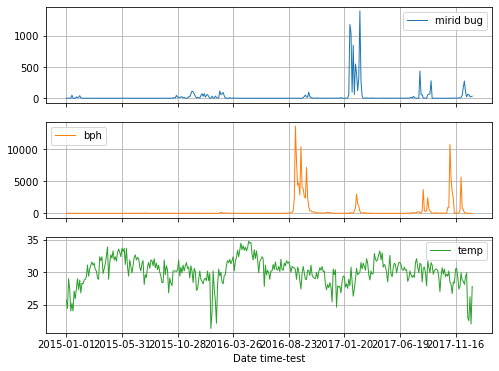

In [22]:
plot_data(frames_train,'test')





In [ ]:
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

In [5]:
train_X, train_y = data_preprocess(frames_train,7,3)
val_X,val_y = data_preprocess(frames_val,7,3)

In [6]:
model = create_model(50,train_X.shape[1],train_X.shape[2],'elu')
# model.summary()

In [7]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# fit network
Epochs = 500
batch_size = 128
history = model.fit(train_X, train_y, 
                    epochs=Epochs, 
                    batch_size=batch_size, 
                    validation_data=(val_X, val_y), 
                    verbose=2, 
                    # callbacks=[cp_callback,es_callback], 
                    # callbacks=[cp_callback],
                    callbacks=[tensorboard_callback],
                    shuffle=False)

# # %tensorboard --logdir logs/fit

Epoch 1/500
292/292 - 8s - loss: 0.0563 - val_loss: 0.0609 - 8s/epoch - 28ms/step
Epoch 2/500
292/292 - 5s - loss: 0.0335 - val_loss: 0.0376 - 5s/epoch - 16ms/step
Epoch 3/500
292/292 - 5s - loss: 0.0229 - val_loss: 0.0266 - 5s/epoch - 16ms/step
Epoch 4/500
292/292 - 5s - loss: 0.0159 - val_loss: 0.0183 - 5s/epoch - 16ms/step
Epoch 5/500
292/292 - 5s - loss: 0.0109 - val_loss: 0.0120 - 5s/epoch - 17ms/step
Epoch 6/500
292/292 - 5s - loss: 0.0081 - val_loss: 0.0133 - 5s/epoch - 16ms/step
Epoch 7/500
292/292 - 4s - loss: 0.0069 - val_loss: 0.0120 - 4s/epoch - 15ms/step
Epoch 8/500
292/292 - 4s - loss: 0.0072 - val_loss: 0.0165 - 4s/epoch - 15ms/step
Epoch 9/500
292/292 - 4s - loss: 0.0068 - val_loss: 0.0154 - 4s/epoch - 14ms/step
Epoch 10/500
292/292 - 4s - loss: 0.0062 - val_loss: 0.0147 - 4s/epoch - 15ms/step
Epoch 11/500
292/292 - 4s - loss: 0.0056 - val_loss: 0.0100 - 4s/epoch - 14ms/step
Epoch 12/500
292/292 - 5s - loss: 0.0058 - val_loss: 0.0107 - 5s/epoch - 15ms/step
Epoch 13/500


In [9]:
# evaluate the model
loss, acc = model.evaluate(val_X, val_y, verbose=2)
var_loss = round(loss,5)
print('Accuracy : ', acc)
print('var_loss is : ', var_loss)

776/776 - 2s - loss: 0.0021 - 2s/epoch - 3ms/step


TypeError: cannot unpack non-iterable float object

In [12]:
# Load the TensorBoard notebook extension
%load_ext tensorboard


%tensorboard --logdir logs/fit
# Clear any logs from previous runs
# rm -rf ./logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17248), started 1 day, 13:47:14 ago. (Use '!kill 17248' to kill it.)